# MyGamePass #
## Steam Master Data Clean Up ##

A combined dataset from Steam of over 27,000 games with extensive descriptive information collected from the Steam store and Steam Spy API, packaged and published to Kaggle by Nik Davis. 

https://www.kaggle.com/nikdavis/steam-store-games

Three files will be used from this dataset.  This notebook will focus on the steam.csv

The steam.csv master file contains the appid and store information for each game, and it will be merged with the description for each game found in the steam_description_data.csv file.  

Additionally, the steamspy_tag dataframe which includes the counts of each key term for each game will be used for content filtering.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in the master dataframe and take a look
steam_df = pd.read_csv('data/steam_store/steam.csv')
steam_df.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99


- This is a lot of great data.  And looks fairly clean and usable, but will need to be preprocessed.

In [3]:
steam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

- 27,075 rows (games) 18 columns (features)

Column: Description
- **appid**: unique id for each game in the database
- **name**: name of game
- **release_date**: release date of video game
- **english**: yes/no (1/0) if the language is english (I will focus only on English games)
- **developer**: the name of the development team that made the game (Example: BioWare developed Mass Effect 2)
- **publisher**: the name of the company that published the game (Example: Electronic Arts published Mass Effect 2)
- **platforms**: the platforms the game is available on (PC, Mac, or Linux)
- **required_age**: the age rating for the game (Mature vs. Family games)
- **categories**: the different game modes and types (single-player, online multi-player, etc.)
- **genres**: the genres of the game (Action, Adventure, Puzzle, etc.)
- **steamspy_tags**: similar to genre and categories, but with key search tags (FPS, esports, zombies, etc)
- **achievements**: yes/no if the game has achievements to unlock for user score (some gamers play games exclusively to level up their score)
- **positive_ratings**: number of positive ratings
- **negative_ratings**: number of negative ratings
- **average_playtime**: average number of hours played per user
- **median_playtime**: median number of hours played per user
- **owners**: total sales of the game, in ranges (game sales are not clearly reported)
- **price**: price of the game in USD

In [4]:
# Confirm the game ids are unique
len(steam_df['appid'].unique())

27075

In [5]:
# Let's check for any duplicated entries
steam_df.duplicated().any()

False

- There is some great data in the ratings information, however I am going to modify it for ease of use
- In lieu of any other information, the default recommendation would be the highest rated games across the total population

In [6]:
# Calculate percentage of positive reviews and total reviews
steam_df['total_ratings'] = steam_df['positive_ratings'] + steam_df['negative_ratings']
steam_df['percent_positive_ratings'] = steam_df['positive_ratings'] / steam_df['total_ratings']
steam_df.drop(['positive_ratings','negative_ratings'],axis=1,inplace=True)
steam_df.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,average_playtime,median_playtime,owners,price,total_ratings,percent_positive_ratings
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,17612,317,10000000-20000000,7.19,127873,0.973888
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,3.99,3951,0.839787
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,187,34,5000000-10000000,3.99,3814,0.895648


- Still have a bit of work left if this will be used as a matrix for comparing similarity
- Next I will convert these owners into bins low, medium, high, and extreme

In [7]:
# I need to convert those strings to ints to bin them.  First split by the '-'
steam_df['owners'] = steam_df['owners'].str.split('-').str[1]
steam_df['owners'] = steam_df['owners'].astype('int64')

In [8]:
# Now I will use my trusty qcut function to set up the bins
bins = [0,20000,50000,100000,np.inf]
#labels = ['low_sales','med_sales','high_sales','extreme_sales']
sales_bins = pd.cut(steam_df['owners'],bins=bins)

# Let's see how it turned out
sales_bins.value_counts()

(0.0, 20000.0]         18596
(100000.0, inf]         3725
(20000.0, 50000.0]      3059
(50000.0, 100000.0]     1695
Name: owners, dtype: int64

- As this shows, the large majority of the games in the dataset are low sales.  However, maybe this recommender system can find new fans for them

In [9]:
# Create the new dummy columns
steam_df['is_low_sales'] = np.where(steam_df['owners'] <= 20000,1,0)
steam_df['is_med_sales'] = np.where((steam_df['owners'] > 20000) & (steam_df['owners'] <= 50000),1,0)
steam_df['is_high_sales'] = np.where((steam_df['owners'] > 50000) & (steam_df['owners'] <= 100000),1,0)
steam_df['is_extreme_sales'] = np.where(steam_df['owners'] > 100000,1,0)

In [10]:
# Drop the relic owners column
steam_df.drop('owners',1,inplace=True)

In [11]:
# Platforms will be converted with get dummies in a similar fashion
steam_df = pd.concat([steam_df.drop('platforms',1),steam_df['platforms'].str.get_dummies(sep=';')],1)
steam_df.head(3)

,appid,name,release_date,english,developer,publisher,required_age,categories,genres,steamspy_tags,...,price,total_ratings,percent_positive_ratings,is_low_sales,is_med_sales,is_high_sales,is_extreme_sales,linux,mac,windows
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,...,7.19,127873,0.973888,0,0,0,1,1,1,1
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,...,3.99,3951,0.839787,0,0,0,1,1,1,1
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,...,3.99,3814,0.895648,0,0,0,1,1,1,1


In [12]:
# Same approach with categories
# steam_df = pd.concat([steam_df.drop('categories',1),steam_df['categories'].str.get_dummies(sep=';')],1)

# Drop genres and steamspy_tags - these will be 
steam_df.drop(['genres','steamspy_tags'],1,inplace=True)

In [13]:
steam_df.head(3)

,appid,name,release_date,english,developer,publisher,required_age,categories,achievements,average_playtime,...,price,total_ratings,percent_positive_ratings,is_low_sales,is_med_sales,is_high_sales,is_extreme_sales,linux,mac,windows
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,0,17612,...,7.19,127873,0.973888,0,0,0,1,1,1,1
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,0,277,...,3.99,3951,0.839787,0,0,0,1,1,1,1
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,0,Multi-player;Valve Anti-Cheat enabled,0,187,...,3.99,3814,0.895648,0,0,0,1,1,1,1


- Don't forget, we only want english games

In [14]:
# Let's first double check the breakdown
steam_df['english'].value_counts()

1    26564
0      511
Name: english, dtype: int64

In [15]:
# Looks fine to drop the non-english games
steam_df = steam_df[steam_df['english']==1]
# and drop the english column now
steam_df.drop('english',1,inplace=True)

### Average Playtime ###
- Let's take a look at that average playtime.  Could be very useful

<AxesSubplot:xlabel='average_playtime', ylabel='Count'>

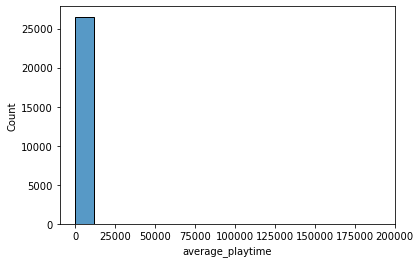

In [16]:
sns.histplot(steam_df['average_playtime'])

<AxesSubplot:xlabel='average_playtime'>

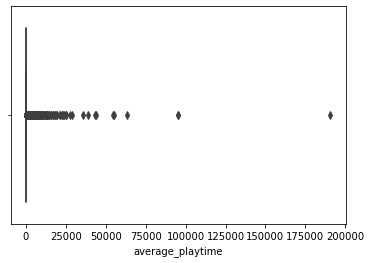

In [17]:
sns.boxplot(x=steam_df['average_playtime'])

In [18]:
steam_df['average_playtime'].describe()

count     26564.000000
mean        149.890717
std        1824.209705
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      190625.000000
Name: average_playtime, dtype: float64

In [19]:
steam_df['median_playtime'].describe()

count     26564.000000
mean        144.940747
std        2334.541203
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      190625.000000
Name: median_playtime, dtype: float64

In [20]:
cutoff = 300

In [21]:
len(steam_df[steam_df['average_playtime'] > cutoff])

1953

- Yikes...looks like some major outliers again
- Because I do not want to drop any rows from this master dataframe, I am going to hardcode the maximum average playtime to 300 hours

In [22]:
# If the average is above 300, set it to 300, else leave it alone
steam_df['average_playtime'] = np.where(steam_df['average_playtime'] > cutoff,cutoff,steam_df['average_playtime'])

<AxesSubplot:xlabel='average_playtime', ylabel='Count'>

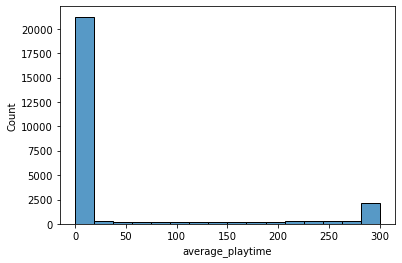

In [23]:
sns.histplot(steam_df['average_playtime'])

- Interesting.  It looks like there are thousands of games with very little playtime.  Let's examine this closer

In [24]:
# How many games have an average playtime of less than 1, 
# implying that everyone hated the game and did not play it (and should not be recommended)
len(steam_df[steam_df['average_playtime'] < 1])

20439

In [25]:
steam_df[steam_df['average_playtime'] < 1]

,appid,name,release_date,developer,publisher,required_age,categories,achievements,average_playtime,median_playtime,price,total_ratings,percent_positive_ratings,is_low_sales,is_med_sales,is_high_sales,is_extreme_sales,linux,mac,windows
26,1002,Rag Doll Kung Fu,2005-10-12,Mark Healey,Mark Healey,0,Single-player;Multi-player,0,0,0,5.99,57,0.701754,0,1,0,0,0,0,1
29,1300,SiN Episodes: Emergence,2006-05-10,Ritual Entertainment,Ritual Entertainment,0,Single-player;Stats,0,0,0,7.19,529,0.884688,0,0,0,1,0,0,1
34,1600,Dangerous Waters,2006-02-07,Sonalysts,Strategy First,0,Single-player;Multi-player,0,0,0,22.99,184,0.760870,0,0,1,0,0,0,1
35,1610,Space Empires IV Deluxe,2006-02-07,Malfador Machinations,Strategy First,0,Single-player;Multi-player,0,0,0,6.99,138,0.811594,0,0,1,0,0,0,1
36,1630,Disciples II: Rise of the Elves,2006-07-06,Strategy First,Strategy First,0,Single-player;Multi-player;Co-op,0,0,0,4.99,559,0.806798,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,0,Single-player;Steam Achievements,7,0,0,2.09,3,1.000000,1,0,0,0,0,0,1
27071,1065570,Cyber Gun,2019-04-23,Semyon Maximov,BekkerDev Studio,0,Single-player,0,0,0,1.69,9,0.888889,1,0,0,0,0,0,1
27072,1065650,Super Star Blast,2019-04-24,EntwicklerX,EntwicklerX,0,Single-player;Multi-player;Co-op;Shared/Split ...,24,0,0,3.99,1,0.000000,1,0,0,0,0,0,1
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,Yustas Game Studio,Alawar Entertainment,0,Single-player;Steam Cloud,0,0,0,5.19,2,1.000000,1,0,0,0,0,1,1


## Removing the unworthy games ##

- 20,439 games is a lot to drop without looking closer..
- Let's drop the game if the average_playtime is less than 1 and if the ratings indicators are poor
- Ratings indicators will be if there are very little overall ratings or if the ratings average is negative
- This would confirm it is a game I would not recommend to a friend
- When joining on this dataframe and inner joine will filter the other datasets as well

In [26]:
# let's take a look at all of these games to confirm
steam_df[(steam_df['average_playtime'] < 1) & 
         ((steam_df['total_ratings']<10) | (steam_df['percent_positive_ratings'] < 0.5))]

,appid,name,release_date,developer,publisher,required_age,categories,achievements,average_playtime,median_playtime,price,total_ratings,percent_positive_ratings,is_low_sales,is_med_sales,is_high_sales,is_extreme_sales,linux,mac,windows
87,3230,Genesis Rising,2007-08-06,Metamorf,THQ Nordic,0,Single-player;Multi-player,0,0,0,4.49,124,0.241935,0,1,0,0,0,0,1
118,3960,Shattered Union,2006-10-25,PopTop,2K,0,Single-player;Multi-player,0,0,0,2.99,88,0.443182,0,1,0,0,0,0,1
122,4100,Poker Superstars II,2006-10-05,Funkitron,Funkitron,0,Single-player,0,0,0,5.99,9,0.444444,1,0,0,0,0,0,1
124,4290,RACE: Caterham Expansion,2007-06-22,SimBin,SimBin,0,Single-player;Multi-player,0,0,0,3.99,6,0.666667,1,0,0,0,0,0,1
160,6270,Ducati World Championship,2007-09-21,Artematica Entertainment,Strategy First,0,Single-player;Multi-player,0,0,0,3.99,177,0.435028,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,0,Single-player;Steam Achievements,7,0,0,2.09,3,1.000000,1,0,0,0,0,0,1
27071,1065570,Cyber Gun,2019-04-23,Semyon Maximov,BekkerDev Studio,0,Single-player,0,0,0,1.69,9,0.888889,1,0,0,0,0,0,1
27072,1065650,Super Star Blast,2019-04-24,EntwicklerX,EntwicklerX,0,Single-player;Multi-player;Co-op;Shared/Split ...,24,0,0,3.99,1,0.000000,1,0,0,0,0,0,1
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,Yustas Game Studio,Alawar Entertainment,0,Single-player;Steam Cloud,0,0,0,5.19,2,1.000000,1,0,0,0,0,1,1


- 8,357 is not an insignificant amount of data to throw away, but the logic is sound.  
- If no one played the game and those that did rated it poorly, it is not worthy of recommendation

In [27]:
unworthy = (steam_df['average_playtime'] < 1) & ((steam_df['total_ratings']<10) | (steam_df['percent_positive_ratings'] < 0.5))

In [28]:
steam_df = steam_df[~unworthy]

In [29]:
steam_df.drop('median_playtime',1,inplace=True)

<AxesSubplot:xlabel='average_playtime', ylabel='Count'>

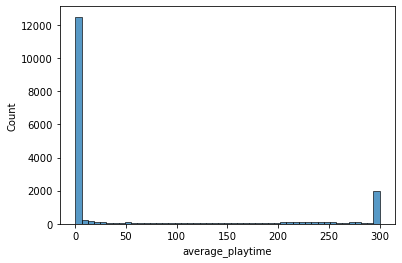

In [30]:
# Let's take a look back at the average playtime distribution now
sns.histplot(steam_df['average_playtime'])

In [31]:
steam_df['average_playtime'].describe()

count    18207.000000
mean        63.211951
std        109.852500
min          0.000000
25%          0.000000
50%          0.000000
75%         81.500000
max        300.000000
Name: average_playtime, dtype: float64

- Alright, that is a lot better at least.  Not ideal, but modifies the extreme/unreasonable higher outliers and removes the unworthy lower

In [32]:
steam_df['required_age'].value_counts()

0     17709
18      262
16      167
12       51
7         9
3         9
Name: required_age, dtype: int64

- 0 could be a placeholder for E/Everyone, or Nulls.  With Such class imbalance and imbiguity, I will simply drop this column.

In [33]:
steam_df.drop('required_age',1,inplace=True)

In [34]:
steam_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18207 entries, 0 to 27067
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     18207 non-null  int64  
 1   name                      18207 non-null  object 
 2   release_date              18207 non-null  object 
 3   developer                 18207 non-null  object 
 4   publisher                 18207 non-null  object 
 5   categories                18207 non-null  object 
 6   achievements              18207 non-null  int64  
 7   average_playtime          18207 non-null  int64  
 8   price                     18207 non-null  float64
 9   total_ratings             18207 non-null  int64  
 10  percent_positive_ratings  18207 non-null  float64
 11  is_low_sales              18207 non-null  int64  
 12  is_med_sales              18207 non-null  int64  
 13  is_high_sales             18207 non-null  int64  
 14  is_ext

In [35]:
# Export to a new csv, and to confirm read it in and print the header
steam_df.to_csv('data/steam_clean.csv',index=False)
newdf = pd.read_csv('data/steam_clean.csv')
newdf.head(3)

,appid,name,release_date,developer,publisher,categories,achievements,average_playtime,price,total_ratings,percent_positive_ratings,is_low_sales,is_med_sales,is_high_sales,is_extreme_sales,linux,mac,windows
0,10,Counter-Strike,2000-11-01,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,0,300,7.19,127873,0.973888,0,0,0,1,1,1,1
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,0,277,3.99,3951,0.839787,0,0,0,1,1,1,1
2,30,Day of Defeat,2003-05-01,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,0,187,3.99,3814,0.895648,0,0,0,1,1,1,1


### And we are ready for modeling! ###